In [7]:
import os
import sys

# 把上一级目录（也就是 project_root）加到 sys.path
sys.path.append(os.path.abspath(".."))

from util.multimodal_align import load_from_dir, compute_pairings, align_many_to_many

# === 1) 配置你数据所在目录 ===
ROOT = r"C:\Users\WangShuai\Desktop\MMDataset\251118"   # 改成你的根目录
RECURSIVE = True                # 递归扫子目录；若只扫一层改为 False
OUT_JSON = "pairings.json"      # 输出的配对JSON文件路径


# 1) 扫描并读取
sensor_metas, sensors, audios = load_from_dir(ROOT, recursive=RECURSIVE)

# 2) 先看覆盖关系（谁和谁时间重叠）
pairs = compute_pairings(sensor_metas, audios)
# print(pairs.sort_values("overlap_sec", ascending=False).head())

# 3) 多对多对齐（每条传感器样本选择最匹配的WAV+sample）
aligned = align_many_to_many(sensors, audios, tolerance_ms=20.0)

# aligned 中关键列：
pairs.sort_values("overlap_sec", ascending=False).head()


,sensor_id,audio_id,sensor_file,wav_path,sensor_start,sensor_end,audio_start,audio_end,overlap_sec
0,2025-11-17_23-44-27-SFM3300AW_24410080.edf,record_20251117T154541Z.wav,C:\Users\WangShuai\Desktop\MMDataset\251118\20...,C:\Users\WangShuai\Desktop\MMDataset\251118\re...,1.763394e+09,1.763397e+09,1.763394e+09,1.763395e+09,599.864263
1,2025-11-17_23-44-27-SFM3300AW_24410080.edf,record_20251117T155659Z.wav,C:\Users\WangShuai\Desktop\MMDataset\251118\20...,C:\Users\WangShuai\Desktop\MMDataset\251118\re...,1.763394e+09,1.763397e+09,1.763395e+09,1.763396e+09,599.864263
2,2025-11-18_00-36-39-SFM3300AW_24400737.edf,record_20251117T163755Z.wav,C:\Users\WangShuai\Desktop\MMDataset\251118\20...,C:\Users\WangShuai\Desktop\MMDataset\251118\re...,1.763397e+09,1.763398e+09,1.763397e+09,1.763398e+09,599.864263


In [2]:
# 配对JSON生成脚本：scan -> pair -> save (最简版)
# 依赖：pip install pandas pyarrow (pandas仅用于友好打印，可去掉)
import json
from pathlib import Path
from util.multimodal_align import load_from_dir, compute_pairings



# === 2) 扫描并读取（自动找所有 .edf / .wav，且wav同名.json会一起读） ===
sensor_metas, sensor_dict, audio_metas = load_from_dir(ROOT, recursive=RECURSIVE)

# === 3) 计算 EDF–WAV 的时间重叠（秒） ===
pairs_df = compute_pairings(sensor_metas, audio_metas)

# 没有任何重叠也没关系，输出空数组
pairs = []
for _, r in pairs_df.iterrows():
    pairs.append({
        "sensor_id":     r["sensor_id"],
        "audio_id":      r["audio_id"],
        "sensor_file":   str(r["sensor_file"]),
        "wav_path":      str(r["wav_path"]),
        "sensor_start":  float(r["sensor_start"]),
        "sensor_end":    float(r["sensor_end"]),
        "audio_start":   float(r["audio_start"]),
        "audio_end":     float(r["audio_end"]),
        "overlap_sec":   float(r["overlap_sec"]),
    })

# === 4) 写出 JSON（UTF-8，无花括号换行便于读） ===
Path(OUT_JSON).write_text(json.dumps(pairs, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"✅ 已写出配对结果：{OUT_JSON}（共 {len(pairs)} 条）")

# === 5)（可选）快速预览前几条 ===
try:
    import pandas as pd
    print(pd.DataFrame(pairs).head())
except Exception:
    pass


✅ 已写出配对结果：pairings.json（共 4 条）
                                    sensor_id                     audio_id  \
0  2025-11-17_23-44-27-SFM3300AW_24410080.edf  record_20251117T154541Z.wav   
1  2025-11-17_23-44-27-SFM3300AW_24410080.edf  record_20251117T155659Z.wav   
2  2025-11-17_23-44-27-SFM3300AW_24410080.edf  record_20251117T161158Z.wav   
3  2025-11-18_00-36-39-SFM3300AW_24400737.edf  record_20251117T163755Z.wav   

                                         sensor_file  \
0  C:\Users\WangShuai\Desktop\MMDataset\251118\20...   
1  C:\Users\WangShuai\Desktop\MMDataset\251118\20...   
2  C:\Users\WangShuai\Desktop\MMDataset\251118\20...   
3  C:\Users\WangShuai\Desktop\MMDataset\251118\20...   

                                            wav_path  sensor_start  \
0  C:\Users\WangShuai\Desktop\MMDataset\251118\re...  1.763394e+09   
1  C:\Users\WangShuai\Desktop\MMDataset\251118\re...  1.763394e+09   
2  C:\Users\WangShuai\Desktop\MMDataset\251118\re...  1.763394e+09   
3  C:\Users\WangS

audio shape: (960000,) sr: 48000
sensors in window: ['2025-10-26_18-47-52-SFM3300AW_24410080.edf']


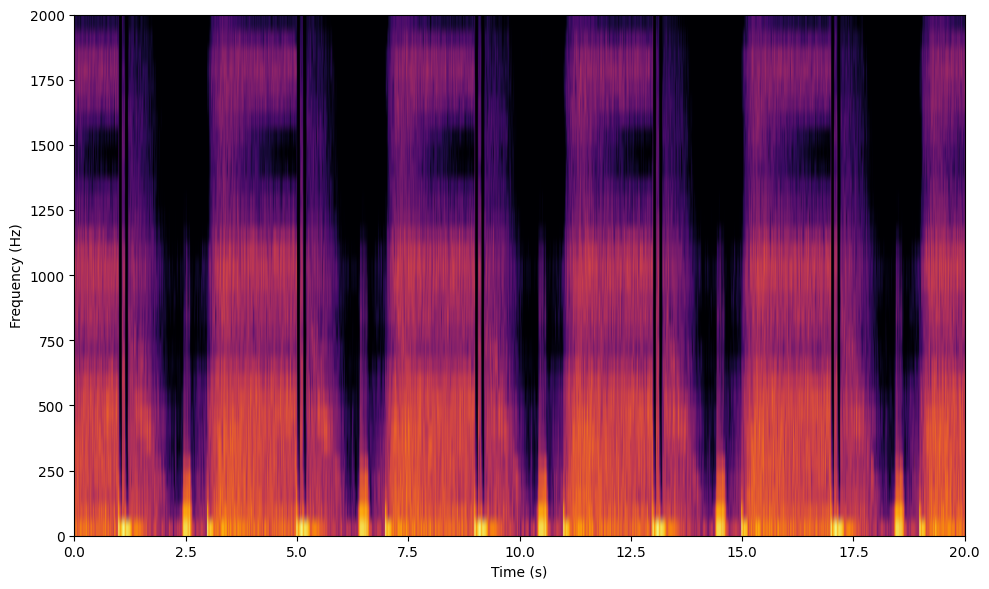

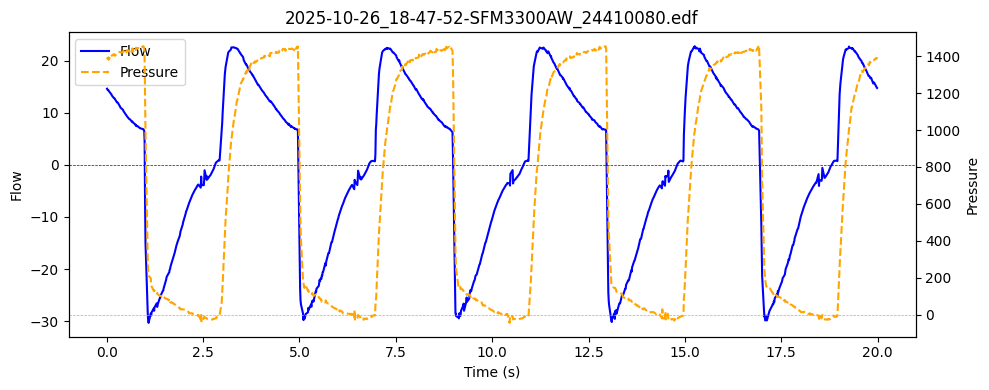

In [3]:
import os
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

from util.multimodal_align import (
    load_from_dir,
    compute_pairings,
)

# ========== 1) 画 mel 的函数（可指定 fmin/fmax 和 cmap） ==========
def draw_mel(y, sr, f_min=50, f_max=20000, n_mels=80, nfft=1024, hop=256, cmap="inferno"):
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        fmin=f_min,
        fmax=f_max,
        n_fft=nfft,
        hop_length=hop,
    )
    S_dB = librosa.power_to_db(S, ref=np.max)
    # 你之前的做法：拉到 0~255
    S_normalized = (S_dB + 80) / 80 * 255
    S_normalized = S_normalized.astype(np.uint8)

    plt.figure(figsize=(10, 6))
    plt.imshow(
        S_normalized,
        aspect="auto",
        origin="lower",
        extent=[0, S_dB.shape[1] * hop / sr, f_min, f_max],
        cmap=cmap,
    )
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


# ========== 2) 截取一段音频 + 对应传感器的函数 ==========
def extract_window(root_dir, start_utc, duration_sec=20.0, recursive=False):
    # 读取目录下所有模态
    sensor_metas, sensors, audios = load_from_dir(root_dir, recursive=recursive)
    # 先算一下重叠，主要是为了调试
    pairs = compute_pairings(sensor_metas, audios)
    # 找能覆盖这段窗的音频
    end_utc = start_utc + duration_sec
    candidate_audios = []
    for a in audios:
        a_start, a_end = a.time_range  # 音频真正的起止
        if (start_utc >= a_start) and (end_utc <= a_end):
            candidate_audios.append(a)

    if not candidate_audios:
        raise RuntimeError("这段时间没有被任何一段音频完整覆盖，请换一个 start_utc。")

    # 简单起见，取第一段
    audio_meta = candidate_audios[0]

    # 用 librosa 读这段音频
    audio_offset = start_utc - audio_meta.first_sample_utc  # 秒
    y, sr = librosa.load(
        audio_meta.wav_path,
        sr=None,
        mono=True,
        offset=audio_offset,
        duration=duration_sec,
    )

    # 截取传感器
    sensor_window = {}
    for path, df in sensors.items():
        mask = (df["Epoch_UTC"] >= start_utc) & (df["Epoch_UTC"] <= end_utc)
        sub = df.loc[mask].copy()
        if not sub.empty:
            sensor_window[os.path.basename(path)] = sub

    return y, sr, sensor_window, audio_meta


# ========== 3) 画传感器双轴（流速 + 压力） ==========
def plot_flow_pressure(sensor_window, start_utc):
    for sensor_name, df in sensor_window.items():
        t_rel = df["Epoch_UTC"] - start_utc  # 相对秒

        fig, ax_flow = plt.subplots(figsize=(10, 4))

        # 左轴：流速
        ln_list = []
        lb_list = []
        if "F_SFM3300AW_24410080" in df.columns:
            ln1 = ax_flow.plot(
                t_rel,
                df["F_SFM3300AW_24410080"],
                label="Flow",
                color="blue"
            )
            ax_flow.set_xlabel("Time (s)")
            ax_flow.set_ylabel("Flow")
            # 绘制flow = 0 横轴
            ax_flow.axhline(0, color="blue", linestyle="--", linewidth=0.5)
            
            ln_list += ln1
            lb_list += ["Flow"]

        # 右轴：压力
        ax_press = None
        if "P_SFM3300AW_24410080" in df.columns:
            ax_press = ax_flow.twinx()
            ln2 = ax_press.plot(
                t_rel,
                df["P_SFM3300AW_24410080"],
                label="Pressure",
                linestyle="--",
                color="orange",
            )
            # 绘制p = 0 横轴
            ax_press.axhline(0, color="orange", linestyle="--", linewidth=0.5)
            ax_press.set_ylabel("Pressure")
            ln_list += ln2
            lb_list += ["Pressure"]

        if ln_list:
            ax_flow.legend(ln_list, lb_list, loc="best")

        plt.title(sensor_name)
        plt.tight_layout()
        plt.show()


# ========== 4) 一个可直接跑的例子 ==========
if __name__ == "__main__":
    # 你的数据目录
    root_dir = r"C:\Users\WangShuai\Desktop\MMDataset\251026"
    # root_dir = r"C:\Users\WangShuai\Desktop\MMDataset\251107"


    # 选一段音频的开始时间作为窗口起点（这个一定有数据）
    # record_20251026T111717Z.wav => 2025-10-26 11:17:17Z
    start_dt = datetime(2025, 10, 26, 11, 29, 17, tzinfo=timezone.utc)
    # start_dt = datetime(2025, 11, 7, 14, 50, 44, tzinfo=timezone.utc)
    start_utc = start_dt.timestamp()

    # 提取10秒
    y, sr, sensor_window, audio_meta = extract_window(
        root_dir,
        start_utc=start_utc,
        duration_sec=20.0,
        recursive=False,
    )

    print("audio shape:", y.shape, "sr:", sr)
    print("sensors in window:", list(sensor_window.keys()))

    # 1) 画 mel，可调 fmin / fmax / cmap
    draw_mel(
        y,
        sr,
        f_min=0,          # 你想要的最小频率
        f_max=2000,       # 你想要的最大频率
        n_mels=32,
        nfft=1024,
        hop=256,
        cmap="inferno",
    )

    # 2) 画压力+流速
    plot_flow_pressure(sensor_window, start_utc)


In [8]:
import os
from datetime import datetime, timezone
import matplotlib.pyplot as plt

# 用你之前定义过的函数：
# from multimodal_align import (
#     scan_modal_files,
#     read_many_sensor_tsv_edf,
#     read_many_audio_with_json,
#     compute_pairings,
# )

ROOT_DIR = r"./data_session"   # 改成你的目录

def ts_to_dt(ts: float) -> datetime:
    return datetime.fromtimestamp(ts, tz=timezone.utc)

def plot_edf_and_wavs(root_dir: str):
    # 1) 扫描目录：这次把 .tsv 也算成 sensor
    scan = scan_modal_files(
        root_dir,
        recursive=True,
        sensor_suffixes=('.edf', '.tsv'),   # ← 关键改这里
        wav_suffixes=('.wav',),
    )

    sensor_files = scan["sensor_files"]
    wav_files = scan["wav_files"]
    wav_json_map = scan["wav_json_map"]

    if not sensor_files:
        print("没有找到任何 .edf/.tsv 传感器文件，无法画时间轴。")
        return

    # 2) 读 sensor 和 audio
    sensor_metas, sensor_dict = read_many_sensor_tsv_edf(sensor_files)
    audio_metas = []
    for w in wav_files:
        audio_metas.append(read_audio_with_json(w, wav_json_map.get(w)))

    # 3) 计算配对
    pair_df = compute_pairings(sensor_metas, audio_metas)

    # 4) 全局时间范围
    global_start = min(m.start_utc_s for m in sensor_metas)
    global_end   = max(m.end_utc_s   for m in sensor_metas)

    fig, ax = plt.subplots(figsize=(10, 0.8 * len(sensor_metas) + 2))

    # 按开始时间排一下
    sensor_metas_sorted = sorted(sensor_metas, key=lambda m: m.start_utc_s)

    for idx, sm in enumerate(sensor_metas_sorted):
        y = idx
        s_dt = ts_to_dt(sm.start_utc_s)
        e_dt = ts_to_dt(sm.end_utc_s)

        # 画这条 sensor 轴
        ax.hlines(y, s_dt, e_dt, colors="black", linewidth=3)
        ax.text(s_dt, y + 0.15, sm.sensor_id, fontsize=8, ha="left", va="bottom")

        # 找跟它有交集的所有 wav
        sub = pair_df[pair_df["sensor_id"] == sm.sensor_id]
        for _, row in sub.iterrows():
            wav_s = row["audio_start"]
            wav_e = row["audio_end"]

            # 跟这条 sensor 的交集
            vis_s = max(wav_s, sm.start_utc_s)
            vis_e = min(wav_e, sm.end_utc_s)
            if vis_e <= vis_s:
                continue

            ax.hlines(
                y,
                ts_to_dt(vis_s),
                ts_to_dt(vis_e),
                colors="red",
                linewidth=2,
                alpha=0.8,
            )
            ax.text(
                ts_to_dt(vis_s),
                y - 0.25,
                os.path.basename(row["wav_path"]),
                fontsize=6,
                ha="left",
                va="top",
            )

    ax.set_ylim(-1, len(sensor_metas))
    ax.set_yticks([])
    ax.set_xlabel("UTC time")
    ax.set_xlim(ts_to_dt(global_start), ts_to_dt(global_end))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_edf_and_wavs(ROOT_DIR)


NameError: name 'scan_modal_files' is not defined